In [1]:
pip install "numpy>=1.16.5,<1.23.0"

Note: you may need to restart the kernel to use updated packages.


## 데이터 전처리

In [32]:
import numpy as np 
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd
import pickle
import ast
#pd.set_option('display.max_columns', None)
#pd.set_option('display.width', 500)
#pd.set_option('max_colwidth', 150) #Kolondaki verilerin tüm içeriğini görebilmek için
#pd.set_option('display.expand_frame_repr', False)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from IPython.core.interactiveshell import InteractiveShell
# Jupyter 노트북에서 한 셀 내의 모든 문장의 결과를 표시하도록 합니다.
InteractiveShell.ast_node_interactivity = "all"
# 경고 메시지를 무시하도록 설정합니다.
warnings.simplefilter(action='ignore', category=Warning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

이 데이터 세트는 Food.com (구 Genius Kitchen)에서 스크랩한 230,000개의 레시피와 1.1M 사용자-recipe 상호작용(reviews)으로 구성되며, 18년(2000년 1월~2018년 12월)에 걸쳐 구성됩니다.

In [33]:
raw_recipes=pd.read_csv('./kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv')
raw_recipes.head()
raw_recipes.columns
raw_recipes.shape

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

(231637, 12)

In [34]:
raw_interactions=pd.read_csv('./kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv')
raw_interactions.head()
raw_interactions.columns
raw_interactions.shape

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')

(1132367, 5)

In [35]:
import pandas as pd
print(pd.__version__)

2.1.4


In [36]:
pip install --upgrade pandas

Note: you may need to restart the kernel to use updated packages.


In [128]:
ingr_map = df = pd.read_pickle("./kaggle/input/food-com-recipes-and-user-interactions/ingr_map.pkl")

# 이제 ingr_map을 DataFrame으로 사용할 수 있습니다
print(ingr_map.head())
print(ingr_map.columns)
print(ingr_map.shape)

                                            raw_ingr  raw_words  \
0  medium heads bibb or red leaf lettuce, washed,...         13   
1              mixed baby lettuces and spring greens          6   
2                               romaine lettuce leaf          3   
3                               iceberg lettuce leaf          3   
4                                red romaine lettuce          3   

                                           processed  len_proc replaced  \
0  medium heads bibb or red leaf lettuce, washed,...        73  lettuce   
1               mixed baby lettuces and spring green        36  lettuce   
2                               romaine lettuce leaf        20  lettuce   
3                               iceberg lettuce leaf        20  lettuce   
4                                red romaine lettuce        19  lettuce   

   count    id  
0   4507  4308  
1   4507  4308  
2   4507  4308  
3   4507  4308  
4   4507  4308  
Index(['raw_ingr', 'raw_words', 'processed',

In [129]:
#rating (0~5)

# 각 평점 값의 빈도를 계산하고, 결측치를 포함하여 표시합니다.
raw_interactions.rating.value_counts(dropna=False)

NameError: name 'raw_interactions' is not defined

## 평점이 0인 데이터 제거

In [39]:
#등급 = 0인 사람은 제거됩니다.

# 평점이 0인 데이터를 제외하고 나머지 데이터만 선택합니다.
raw_interactions=raw_interactions[raw_interactions.rating>0]

In [40]:
# 'recipe_id' 열에서 고유한 레시피의 수를 계산합니다. 결과적으로 226590개의 고유 레시피가 남습니다.
raw_interactions.recipe_id.nunique() #226590 farklı tarif kaldı

226590

### 평점 0인 데이터를 제외하고 고유한 레시피 수를 계산할 시 226590

In [41]:
#댓글수와 평균에 따른 레시피 그룹

# 'recipe_id'를 기준으로 데이터를 그룹화하고, 각 레시피의 평점 수('count')와 평균 평점('mean')을 계산합니다. 
# 그 후, 열 이름을 재설정하고 평점 수에 따라 내림차순으로 정렬합니다.
grouped=raw_interactions.groupby('recipe_id').agg({'rating':['count', 'mean']}).reset_index()
grouped.columns=grouped.columns.droplevel(0)
grouped.columns=['recipe_id','rating_count','rating_mean']
grouped.sort_values(by='rating_count',ascending=False)

,recipe_id,rating_count,rating_mean
14156,27208,1496,4.589572
50549,89204,1488,4.478495
818,2886,1401,4.819415
21268,39087,1359,4.838852
38015,67256,1194,4.793132
...,...,...,...
120087,219413,1,5.000000
120084,219408,1,3.000000
120082,219404,1,5.000000
120078,219397,1,5.000000


## 평점 40개 이상인 데이터의 갯수와 분포 계산

In [42]:
# 평점이 40개 이상인 레시피의 수를 계산합니다. 결과적으로 2730개의 레시피가 이 기준을 충족합니다.
len(grouped[grouped['rating_count'] >= 40])

# 이 2730개의 레시피 중 최대 평균 평점과 최소 평균 평점을 계산합니다. 평균 평점은 3.4에서 5 사이입니다.
grouped[grouped['rating_count'] >= 40].rating_mean.max(), grouped[grouped['rating_count'] >= 40].rating_mean.min()

# 평점이 40개 이상인 레시피의 평균 평점 분포를 계산합니다.
grouped[grouped['rating_count'] >= 40].rating_mean.value_counts()

2730

(5.0, 3.4693877551020407)

rating_mean
4.800000    30
4.750000    26
4.666667    21
4.714286    19
4.857143    19
            ..
4.520833     1
4.957265     1
4.577844     1
4.522088     1
3.825000     1
Name: count, Length: 1447, dtype: int64

In [43]:
# 평점이 40개 이상인 2730개의 레시피의 ID를 리스트로 추출합니다.
recipes_to_filter = list(grouped[grouped['rating_count'] >= 40].recipe_id)

In [44]:
# 원본 레시피 데이터셋을 평점이 40개 이상인 2730개의 레시피 ID에 해당하는 레시피로 필터링합니다.
filtered_recipes = raw_recipes[raw_recipes.id.isin(recipes_to_filter)]
filtered_recipes.head(3)  # 필터링된 결과의 상위 3개 레시피를 표시합니다.

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
36,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",8
53,land of nod cinnamon buns,22526,35,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"['rolls', 'brown sugar', 'instant vanilla pudd...",6
67,never weep whipped cream,74805,5,87877,2003-11-01,"['15-minutes-or-less', 'time-to-make', 'course...","[276.3, 45.0, 2.0, 1.0, 3.0, 91.0, 0.0]",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...","['whipping cream', 'vanilla instant pudding mi...",4


In [45]:
# 더 이상 사용하지 않는 'raw_recipes'와 'raw_interactions' 데이터셋을 메모리에서 삭제합니다.
del raw_recipes
del raw_interactions

## Filtered Recipes 

### 겹치는 레시피 id제거

In [46]:
# 'filtered_recipes' 데이터셋 내에서 고유한 레시피 ID의 수를 확인합니다. 결과는 2730으로, ID 중복이 없음을 나타냅니다.
filtered_recipes.id.nunique()

# 고유한 레시피 이름의 수를 확인합니다. 결과는 2728로, 2개의 레시피 이름이 중복됩니다.
filtered_recipes.name.nunique()

# 중복된 레시피 이름을 확인합니다. 'roasted brussels sprouts'와 'strawberry rhubarb pie'가 각각 2번 나타납니다.
filtered_recipes.name.value_counts()

2730

2728

name
roasted brussels sprouts                                     2
strawberry rhubarb pie                                       2
how i got my family to eat spinach  spinach casserole        1
on the go ravioli lasagna                                    1
one dish chicken and rice bake                               1
                                                            ..
easiest chocolate peanut butter fudge                        1
easiest tastiest barbecue country style ribs  slow cooker    1
easter nests with jelly bean eggs                            1
easter sunday cheesecake                                     1
zucchini salsa  canned                                       1
Name: count, Length: 2728, dtype: int64

In [47]:
# 'roasted brussels sprouts'와 'strawberry rhubarb pie'라는 이름을 가진 레시피들의 세부 정보를 조회합니다.
filtered_recipes[filtered_recipes.name.isin(['roasted brussels sprouts', 'strawberry rhubarb pie'])]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
175197,roasted brussels sprouts,201073,30,242161,2006-12-19,"['lactose', '30-minutes-or-less', 'time-to-mak...","[165.0, 16.0, 15.0, 13.0, 11.0, 7.0, 5.0]",5,"['preheat oven to 400 degrees f', 'cut the bot...","quick, simple, and unbelievably tasty. this re...","['fresh brussels sprouts', 'extra virgin olive...",6
175222,roasted brussels sprouts,56103,50,37449,2003-03-10,"['60-minutes-or-less', 'time-to-make', 'course...","[101.0, 11.0, 7.0, 9.0, 5.0, 5.0, 2.0]",6,"['preheat oven to 400f', 'cut off the ends of ...",i got this from the barefoot contessa cookbook...,"['brussels sprouts', 'olive oil', 'kosher salt...",4
201246,strawberry rhubarb pie,125515,120,70073,2005-06-10,"['time-to-make', 'course', 'main-ingredient', ...","[178.1, 1.0, 143.0, 0.0, 3.0, 1.0, 14.0]",13,"['in a bowl , combine rhubarb , strawberries ,...",an excellent pie to make when strawberries and...,"['rhubarb', 'strawberries', 'granulated sugar'...",9
201598,strawberry rhubarb pie,7553,40,146310,2000-03-13,"['60-minutes-or-less', 'time-to-make', 'course...","[343.5, 15.0, 176.0, 12.0, 10.0, 17.0, 19.0]",11,"['combine eggs , sugar , flour , salt , and nu...",NaN,"['eggs', 'rhubarb', 'sugar', 'strawberries', '...",9


In [48]:
# 이름이 'roasted brussels sprouts'와 'strawberry rhubarb pie'인 레시피를 제외하고 나머지 레시피만을 선택합니다.
# 중복된 이름을 가진 레시피들이 제거됩니다.
filtered_recipes = filtered_recipes[~filtered_recipes.name.isin(['roasted brussels sprouts', 'strawberry rhubarb pie'])]

# 필터링 후 남은 레시피의 수를 확인합니다. 결과적으로 2726개의 레시피가 남습니다.
len(filtered_recipes)

2726

# Nutrition

## 영양소를 분석을 위해 실수화

In [49]:
# 'nutrition' 열의 데이터를 처리하여 각 영양소(칼로리, 총 지방, 설탕, 나트륨, 단백질, 포화 지방, 탄수화물)별로 분리하고, 
# 이를 새로운 열로 'filtered_recipes' DataFrame에 추가합니다.
filtered_recipes[['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']] = (
    filtered_recipes.nutrition
    .apply(lambda x: x.replace('[', '').replace(']', ''))
    .str.split(",", expand=True)
    .astype('float')
)

# Outlier 탐색

## 0.2 0.8이 최적임을 알 수 있음

In [110]:
# 이상치 관련 함수 정의:

# outlier_thresholds: 주어진 열(col_name)에 대해 하위 및 상위 이상치 임계값을 계산합니다.
def outlier_thresholds(dataframe, col_name, q1, q3):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# check_outlier: 지정된 열에 대해 이상치가 있는지 검사합니다.
def check_outlier(dataframe, col_name, q1, q3):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    return dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None)
    
# replace_with_thresholds: 이상치를 상위 임계값으로 대체합니다.
def replace_with_thresholds(dataframe, variable, q1, q3):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1, q3)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [111]:
# 'filtered_recipes' DataFrame의 기술통계 요약을 출력합니다. 
# 이는 각 열의 카운트, 평균, 표준편차, 최소값, 25%, 50%, 75% 백분위수, 최대값 등의 통계를 포함합니다.
filtered_recipes.describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2720.000000,2720.000000,2.720000e+03,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000
mean,91597.827574,59.929596,2.094275e+06,9.460294,8.837132,389.445037,28.159559,50.251287,27.147794,33.765074,36.188787,11.503676
std,86029.416736,52.768155,5.984276e+07,5.074861,3.552312,293.239590,26.354217,61.319056,27.023117,35.630025,37.388922,10.477054
min,198.000000,1.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31507.500000,25.000000,2.741100e+04,6.000000,6.000000,176.300000,9.000000,8.000000,7.000000,7.000000,8.000000,4.000000
50%,69213.500000,40.000000,5.228200e+04,8.000000,9.000000,311.700000,20.000000,22.000000,18.000000,17.000000,23.000000,9.000000
75%,117068.000000,70.000000,1.113420e+05,12.000000,11.000000,507.300000,39.000000,68.000000,38.000000,53.000000,52.000000,16.000000
max,524863.000000,182.500000,1.802810e+09,25.000000,21.000000,1199.800000,99.500000,208.500000,103.500000,146.000000,138.500000,40.500000


In [52]:
# 'filtered_recipes' DataFrame에 대한 기술통계 요약을 출력하며, 
# 80%, 90%, 95%, 99%의 백분위수를 포함한 추가적인 통계 정보를 제공합니다.
filtered_recipes.describe(percentiles=[0.8, 0.9, 0.95, 0.99])

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2726.000000,2726.000000,2.726000e+03,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000
mean,91408.446809,102.357667,2.089716e+06,9.642333,8.852898,455.402494,34.288701,72.431401,36.111886,38.355833,43.878944,14.264490
std,86029.308475,485.365263,5.977692e+07,5.864597,3.600001,1062.208676,104.739071,182.760306,125.543035,136.190564,126.556888,31.464804
min,198.000000,0.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69182.000000,40.000000,5.228200e+04,8.000000,9.000000,312.350000,20.000000,23.000000,18.000000,17.000000,23.000000,9.000000
80%,134924.000000,85.000000,1.379110e+05,13.000000,12.000000,571.900000,44.000000,87.000000,45.000000,62.000000,59.000000,18.000000
90%,190966.000000,185.000000,2.176570e+05,16.500000,13.500000,823.800000,68.000000,160.500000,67.000000,86.000000,95.000000,27.000000
95%,258450.750000,365.000000,3.228592e+05,20.000000,15.000000,1133.425000,97.000000,263.000000,97.000000,109.000000,134.000000,40.000000
99%,474870.250000,927.500000,1.113008e+06,30.000000,20.000000,2746.700000,217.750000,941.500000,254.250000,184.500000,297.500000,128.750000
max,524863.000000,20190.000000,1.802810e+09,70.000000,29.000000,38680.100000,4317.000000,4601.000000,4554.000000,6540.000000,4960.000000,1188.000000


In [53]:
# 'filtered_recipes' DataFrame의 각 열의 데이터 타입을 출력합니다.
filtered_recipes.dtypes

name                    object
id                       int64
minutes                  int64
contributor_id           int64
submitted               object
tags                    object
nutrition               object
n_steps                  int64
steps                   object
description             object
ingredients             object
n_ingredients            int64
calories               float64
total fat (PDV)        float64
sugar (PDV)            float64
sodium (PDV)           float64
protein (PDV)          float64
saturated fat (PDV)    float64
carbohydrates (PDV)    float64
dtype: object

In [54]:
# 이상치를 처리하기 위해 'filtered_recipes' DataFrame 내의 수치형(numeric) 열을 선택합니다.
# 선택된 열은 'minutes', 'n_steps', 'n_ingredients' 및 영양소 관련 열들입니다.
num_cols = ['minutes', 'n_steps', 'n_ingredients', 'calories', 'total fat (PDV)', 'sugar (PDV)', 
            'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']

In [55]:
# 1% 및 99% 백분위수를 기준으로 각 수치형 열에 대한 이상치 분석을 수행하고 결과를 출력합니다.
print('q1=0.01, q3=0.99를 기준으로 이상치 분석')
for col in num_cols:
    print(f'{col} 열의 이상치 여부: {check_outlier(filtered_recipes, col, q1=0.01, q3=0.99)} / 이상치 범위: {outlier_thresholds(filtered_recipes, col, q1=0.01, q3=0.99)}')

q1=0.01, q3=0.99를 기준으로 이상치 분석
minutes 열의 이상치 여부: True / 이상치 범위: (-1383.75, 2314.25)
n_steps 열의 이상치 여부: False / 이상치 범위: (-40.0, 72.0)
n_ingredients 열의 이상치 여부: False / 이상치 범위: (-25.0, 47.0)
calories 열의 이상치 여부: True / 이상치 범위: (-4072.6124999999997, 6838.287499999999)
total fat (PDV) 열의 이상치 여부: True / 이상치 범위: (-326.625, 544.375)
sugar (PDV) 열의 이상치 여부: True / 이상치 범위: (-1412.25, 2353.75)
sodium (PDV) 열의 이상치 여부: True / 이상치 범위: (-381.375, 635.625)
protein (PDV) 열의 이상치 여부: True / 이상치 범위: (-276.75, 461.25)
saturated fat (PDV) 열의 이상치 여부: True / 이상치 범위: (-446.25, 743.75)
carbohydrates (PDV) 열의 이상치 여부: True / 이상치 범위: (-193.125, 321.875)


In [56]:
# 5% 및 95% 백분위수를 기준으로 각 수치형 열에 대한 이상치 분석을 수행하고 결과를 출력합니다.
print('q1=0.05, q3=0.95를 기준으로 이상치 분석')
for col in num_cols:
    print(f'{col} 열의 이상치 여부: {check_outlier(filtered_recipes, col, q1=0.05, q3=0.95)} / 이상치 범위: {outlier_thresholds(filtered_recipes, col, q1=0.05, q3=0.95)}')

q1=0.05, q3=0.95를 기준으로 이상치 분석
minutes 열의 이상치 여부: True / 이상치 범위: (-532.5, 903.5)
n_steps 열의 이상치 여부: True / 이상치 범위: (-22.5, 45.5)
n_ingredients 열의 이상치 여부: False / 이상치 범위: (-12.5, 31.5)
calories 열의 이상치 여부: True / 이상치 범위: (-1521.575, 2726.425)
total fat (PDV) 열의 이상치 여부: True / 이상치 범위: (-145.5, 242.5)
sugar (PDV) 열의 이상치 여부: True / 이상치 범위: (-394.5, 657.5)
sodium (PDV) 열의 이상치 여부: True / 이상치 범위: (-143.0, 241.0)
protein (PDV) 열의 이상치 여부: True / 이상치 범위: (-161.0, 271.0)
saturated fat (PDV) 열의 이상치 여부: True / 이상치 범위: (-201.0, 335.0)
carbohydrates (PDV) 열의 이상치 여부: True / 이상치 범위: (-60.0, 100.0)


In [57]:
# 20% 및 80% 백분위수를 기준으로 각 수치형 열에 대한 이상치 분석을 수행하고 결과를 출력합니다.
print('q1=0.2, q3=0.8를 기준으로 이상치 분석')
for col in num_cols:
    print(f'{col} 열의 이상치 여부: {check_outlier(filtered_recipes, col, q1=0.2, q3=0.8)} / 이상치 범위: {outlier_thresholds(filtered_recipes, col, q1=0.2, q3=0.8)}')

q1=0.2, q3=0.8를 기준으로 이상치 분석
minutes 열의 이상치 여부: True / 이상치 범위: (-77.5, 182.5)
n_steps 열의 이상치 여부: True / 이상치 범위: (-7.0, 25.0)
n_ingredients 열의 이상치 여부: True / 이상치 범위: (-3.0, 21.0)
calories 열의 이상치 여부: True / 이상치 범위: (-474.59999999999997, 1199.8)
total fat (PDV) 열의 이상치 여부: True / 이상치 범위: (-48.5, 99.5)
sugar (PDV) 열의 이상치 여부: True / 이상치 범위: (-115.5, 208.5)
sodium (PDV) 열의 이상치 여부: True / 이상치 범위: (-52.5, 103.5)
protein (PDV) 열의 이상치 여부: True / 이상치 범위: (-78.0, 146.0)
saturated fat (PDV) 열의 이상치 여부: True / 이상치 범위: (-73.5, 138.5)
carbohydrates (PDV) 열의 이상치 여부: True / 이상치 범위: (-19.5, 40.5)


### 아웃라이어 하한 0.2 상한 0.8로 설정

In [58]:
for col in num_cols:
    replace_with_thresholds(filtered_recipes, col, q1=0.2, q3=0.8)

In [59]:
filtered_recipes.describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2726.000000,2726.000000,2.726000e+03,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000
mean,91408.446809,59.797689,2.089716e+06,9.466985,8.841526,389.851724,28.181585,50.436720,27.139398,33.781731,36.185437,11.524028
std,86029.308475,52.784826,5.977692e+07,5.077980,3.552673,293.220108,26.339600,61.457033,27.010097,35.634450,37.352008,10.488643
min,198.000000,0.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31321.000000,25.000000,2.739500e+04,6.000000,6.000000,176.800000,9.000000,8.000000,7.250000,7.000000,8.000000,4.000000
50%,69182.000000,40.000000,5.228200e+04,8.000000,9.000000,312.350000,20.000000,23.000000,18.000000,17.000000,23.000000,9.000000
75%,116994.250000,70.000000,1.111410e+05,12.000000,11.000000,507.675000,39.000000,68.000000,38.000000,53.000000,52.000000,16.000000
max,524863.000000,182.500000,1.802810e+09,25.000000,21.000000,1199.800000,99.500000,208.500000,103.500000,146.000000,138.500000,40.500000


### 조리시간이 0인 데이터 제거

In [60]:
#  'minutes' 열의 값이 0인 모든 행(레시피)을 선택합니다.
# 이는 조리 시간이 0분으로 기록된 레시피들을 확인하는 데 사용됩니다. 
filtered_recipes[filtered_recipes.minutes==0] #veriden cikarilir

# 'minutes' 값이 0인 행을 제외하고 나머지 행만을 선택하여 filtered_recipes DataFrame에 다시 할당합니다. 여기서 ~ 연산자는 불리언 인덱싱에서 '아닌(not)'을 의미하므로, 'minutes'가 0이 아닌 모든 행을 선택하게 됩니다.
filtered_recipes= filtered_recipes[~(filtered_recipes.minutes==0)]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
32319,buttermilk southern fried chicken,3294,0.0,64203,1999-10-11,"['15-minutes-or-less', 'time-to-make', 'main-i...","[655.4, 55.0, 24.0, 60.0, 99.0, 52.0, 10.0]",13,"['wash chicken pieces thoroughly and pat dry',...",NaN,"['frying chickens', 'buttermilk', 'all-purpose...",9,655.4,55.0,24.0,60.0,99.0,52.0,10.0
72961,double chocolate banana muffins,9327,0.0,6357,2001-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[403.4, 25.0, 159.0, 13.0, 9.0, 27.0, 21.0]",6,"['in a large bowl , combine the first six ingr...",NaN,"['flour', 'sugar', 'baking cocoa', 'baking sod...",10,403.4,25.0,159.0,13.0,9.0,27.0,21.0
81608,fabulous zucchini bread,3877,0.0,1534,1999-11-02,"['15-minutes-or-less', 'time-to-make', 'course...","[927.0, 45.0, 332.0, 40.0, 35.0, 22.0, 51.0]",11,"['preheat oven to 350 degrees', 'cream togethe...",NaN,"['eggs', 'applesauce', 'oil', 'granulated suga...",17,927.0,45.0,208.5,40.0,35.0,22.0,40.5
110614,illinois apple pie,8423,0.0,64203,2000-03-16,"['15-minutes-or-less', 'time-to-make', 'course...","[711.3, 57.0, 224.0, 9.0, 10.0, 50.0, 31.0]",24,"['preheat oven to 450 degrees', 'for crust , c...",i adopted this recipe during the recipezaar ab...,"['all-purpose flour', 'salt', 'crisco shorteni...",12,711.3,57.0,208.5,9.0,10.0,50.0,31.0
129344,mandarin pork chops,4143,0.0,1543,1999-11-07,"['15-minutes-or-less', 'time-to-make', 'main-i...","[477.3, 33.0, 87.0, 5.0, 84.0, 32.0, 9.0]",10,"['in large skillet , brown chops in oil', 'rem...",NaN,"['pork chops', 'vegetable oil', 'orange juice'...",10,477.3,33.0,87.0,5.0,84.0,32.0,9.0
220660,vanilla pudding,4271,0.0,1534,1999-11-11,"['15-minutes-or-less', 'time-to-make', 'course...","[270.9, 14.0, 120.0, 13.0, 11.0, 25.0, 13.0]",11,"['in medium double boiler , cook sugar , corns...",NaN,"['sugar', 'cornstarch', 'milk', 'salt', 'egg y...",7,270.9,14.0,120.0,13.0,11.0,25.0,13.0


In [61]:
#filtered_recipes[filtered_recipes.n_steps==1] #veride tutulur

In [62]:
#filtered_recipes[filtered_recipes.n_ingredients==2]  #veride tutulur

In [63]:
#filtered_recipes[filtered_recipes.calories<=5] #veride tutulur

In [64]:
# 데이터셋의 인덱스를 0부터 다시 시작하도록 재설정합니다.
# 이를 위해 reset_index 함수를 사용하며, drop=True 파라미터를 통해 기존 인덱스를 새로운 인덱스로 대체하고, inplace=True 파라미터를 사용하여 변경 사항을 데이터프레임에 즉시 적용합니다.
# 이제 데이터셋의 새로운 인덱스가 0부터 시작합니다.
filtered_recipes.reset_index(drop=True, inplace=True)

In [65]:
# 'id'와 'name' 열만을 선택하여 'final_recipes.csv'라는 파일로 저장합니다.
# index를 저장하지 않기 위해 index=False 옵션을 사용하였습니다.
filtered_recipes[['id','name']].to_csv('final_repices.csv',index=False) #sadece id-name eslesmesi

In [66]:
filtered_recipes.describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2720.000000,2720.000000,2.720000e+03,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000
mean,91597.827574,59.929596,2.094275e+06,9.460294,8.837132,389.445037,28.159559,50.251287,27.147794,33.765074,36.188787,11.503676
std,86029.416736,52.768155,5.984276e+07,5.074861,3.552312,293.239590,26.354217,61.319056,27.023117,35.630025,37.388922,10.477054
min,198.000000,1.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31507.500000,25.000000,2.741100e+04,6.000000,6.000000,176.300000,9.000000,8.000000,7.000000,7.000000,8.000000,4.000000
50%,69213.500000,40.000000,5.228200e+04,8.000000,9.000000,311.700000,20.000000,22.000000,18.000000,17.000000,23.000000,9.000000
75%,117068.000000,70.000000,1.113420e+05,12.000000,11.000000,507.300000,39.000000,68.000000,38.000000,53.000000,52.000000,16.000000
max,524863.000000,182.500000,1.802810e+09,25.000000,21.000000,1199.800000,99.500000,208.500000,103.500000,146.000000,138.500000,40.500000


#### filtered_recipes에 있는 태그들을 모두 가져오고 각 태그들이 몇번 등장하는지 출력

In [72]:
import ast

tag_lists = filtered_recipes.tags.tolist()
merged_list = []

# 문자열로 된 리스트를 실제 리스트로 변환
for tag_list in tag_lists:
    try:
        tags = ast.literal_eval(tag_list)
        if isinstance(tags, list):
            merged_list.extend(tags)
    except:
        # 태그 리스트 변환 중 오류 발생 시 예외 처리
        pass

distinct_tags = list(set(merged_list))
print(len(distinct_tags))
print(distinct_tags)


414
['', 'broil', 'corn', 'amish-mennonite', 'pennsylvania-dutch', 'curries', 'german', 'garnishes', 'mashed-potatoes', 'penne', 'ecuadorean', '30-minutes-or-less', 'grapes', 'vietnamese', 'tuna', 'kiwifruit', 'kwanzaa', 'veal', 'welsh', 'from-scratch', 'pasta-shells', 'bar-cookies', 'canning', 'collard-greens', 'danish', 'quick-breads', 'independence-day', 'european', 'oaxacan', 'pies', 'gumbo', 'scallops', 'burgers', 'appetizers', 'pacific-northwest', 'refrigerator', 'desserts', 'australian', 'herb-and-spice-mixes', 'hungarian', 'italian', 'stocks', 'low-in-something', 'elbow-macaroni', 'broccoli', 'orange-roughy', 'portuguese', 'melons', 'yeast', 'pork-loins', 'equipment', 'omelets-and-frittatas', 'hanukkah', 'frozen-desserts', 'lactose', 'potluck', 'chicken-breasts', 'russian', 'pork', 'asian', 'christmas', 'unprocessed-freezer', 'easy', 'for-1-or-2', 'crusts-pastry-dough-2', 'ramadan', 'thai', 'moroccan', 'biscotti', 'elk', 'medium-grain-rice', 'american', 'irish', 'pasta-rice-and

In [73]:
import ast
from collections import Counter

# 문자열 형태의 리스트를 파이썬 리스트로 변환
def convert_string_to_list(string):
    try:
        return ast.literal_eval(string)
    except:
        return []

# filtered_recipes의 'tags' 컬럼을 변환
filtered_recipes['tags_list'] = filtered_recipes['tags'].apply(convert_string_to_list)

# 모든 태그를 하나의 리스트로 합치기
all_tags = [tag for tags_list in filtered_recipes['tags_list'] for tag in tags_list]

# 태그의 빈도수 계산
tag_counts = Counter(all_tags)

# DataFrame으로 변환
tag_frequencies = pd.DataFrame(tag_counts.items(), columns=['tag', 'frequency'])

# 빈도수에 따라 정렬
tag_frequencies = tag_frequencies.sort_values(by='frequency', ascending=False).reset_index(drop=True)

# 결과 출력
print(tag_frequencies)


                     tag  frequency
0            preparation       2716
1           time-to-make       2690
2                 course       2622
3                dietary       2413
4        main-ingredient       2164
..                   ...        ...
409            manicotti          1
410            kiwifruit          1
411            norwegian          1
412             nut-free          1
413  unprocessed-freezer          1

[414 rows x 2 columns]


In [74]:
tag_frequencies.describe().T

,count,mean,std,min,25%,50%,75%,max
frequency,414.0,139.908213,348.601219,1.0,5.0,22.0,112.75,2716.0


### 140번 이상 등장하는 tag는 85개

In [75]:
#평균 빈도 이하의 태그는 사용자가 선택할 수 있는 목록에 포함되지 않습니다.
tag_frequencies=tag_frequencies[~(tag_frequencies.frequency<140)]
len(tag_frequencies)

85

In [76]:
# 가장 자주 사용되는 85개의 태그를 csv
tag_frequencies[['tag']].to_csv('final_tags.csv',index=False) 

#### 레시피에 있는 재료들을 모두 가져오기

In [112]:
pp_recipes=pd.read_csv('./kaggle/input/food-com-recipes-and-user-interactions/PP_recipes.csv')
filtered_pp=pp_recipes[pp_recipes.id.isin(filtered_recipes.id)]
import ast
filtered_pp['ingredient_id_eval'] =filtered_pp.ingredient_ids.apply(ast.literal_eval)
merged_ing_ids = set([value for sublist in filtered_pp.ingredient_id_eval for value in sublist])
len(merged_ing_ids)
ingr_map_filtered=ingr_map[ingr_map.id.isin(merged_ing_ids)]
final_ingr_list=list(set(ingr_map_filtered.replaced))

final_ingr_list=pd.DataFrame(final_ingr_list)
final_ingr_list.columns=['INGREDIENT']
final_ingr_list.to_csv('final_ingredients.csv',index=False)

print(final_ingr_list)

1712

              INGREDIENT
0                   corn
1          vanilla wafer
2             soya sauce
3            white onion
4       fresh breadcrumb
...                  ...
1707    lifesavers candy
1708       savoy cabbage
1709  pumpernickel round
1710    fresh gingerroot
1711       unsifted flmy

[1712 rows x 1 columns]


In [81]:
filtered_recipes.describe() 

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,2720.000000,2720.000000,2.720000e+03,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000,2720.000000
mean,91597.827574,59.929596,2.094275e+06,9.460294,8.837132,389.445037,28.159559,50.251287,27.147794,33.765074,36.188787,11.503676
std,86029.416736,52.768155,5.984276e+07,5.074861,3.552312,293.239590,26.354217,61.319056,27.023117,35.630025,37.388922,10.477054
min,198.000000,1.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31507.500000,25.000000,2.741100e+04,6.000000,6.000000,176.300000,9.000000,8.000000,7.000000,7.000000,8.000000,4.000000
50%,69213.500000,40.000000,5.228200e+04,8.000000,9.000000,311.700000,20.000000,22.000000,18.000000,17.000000,23.000000,9.000000
75%,117068.000000,70.000000,1.113420e+05,12.000000,11.000000,507.300000,39.000000,68.000000,38.000000,53.000000,52.000000,16.000000
max,524863.000000,182.500000,1.802810e+09,25.000000,21.000000,1199.800000,99.500000,208.500000,103.500000,146.000000,138.500000,40.500000


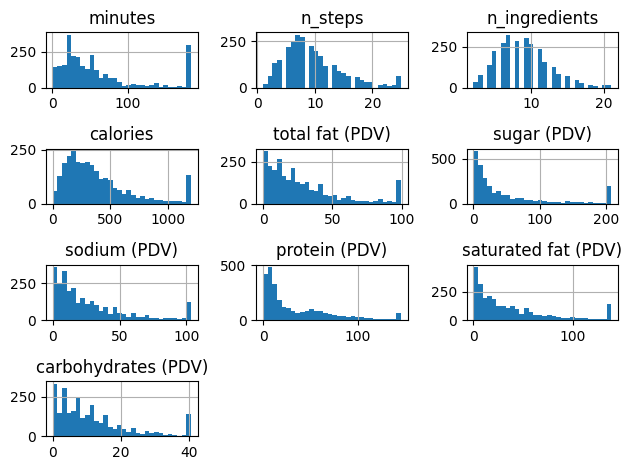

In [82]:
%matplotlib inline
fig, ax = plt.subplots()
filtered_recipes[num_cols].hist(ax=ax, bins=30)
fig.tight_layout()
plt.show();

#### Pisirme suresi (40 dk alti-Less than 40 mins & ustu - More than 40 mins)
#### Kalori Kisitlamasi  (400 cal alti-Low Calory & ustu - High Calory)

### Nihai segment karari :

SEG1 - Less than 40 minutes & Low Calory

SEG2 - Less than 40 minutes & High Calory

SEG3 - More than 40 minutes & Low Calory

SEG4 - More than 40 minutes & High Calory

In [83]:
#세그먼트당 레시피 개수를 살펴봅니다.
print('SEG1 - Less than 40 minutes & Low Calory :',len(filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories<=400)]))
print('SEG2 - Less than 40 minutes & High Calory :',len(filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories>400)]))
print('SEG3 - More than 40 minutes & Low Calory :',len(filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories<=400)]))
print('SEG4 - More than 40 minutes & High Calory :',len(filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories>400)]))

SEG1 - Less than 40 minutes & Low Calory : 1001
SEG2 - Less than 40 minutes & High Calory : 393
SEG3 - More than 40 minutes & Low Calory : 734
SEG4 - More than 40 minutes & High Calory : 592


In [114]:
#SEG 1
filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories<=400)].describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,1001.000000,1001.000000,1.001000e+03,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,93481.702298,22.998002,3.704392e+06,7.728272,7.871129,200.257742,13.899101,32.338162,16.001499,16.911089,17.654346,6.571429
std,83470.188157,10.752767,8.053025e+07,3.776253,3.162337,100.940531,11.091294,37.987949,19.083782,19.209453,17.583868,5.297088
min,198.000000,1.000000,2.700000e+01,1.000000,2.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33245.000000,15.000000,2.764300e+04,5.000000,5.000000,120.800000,5.000000,5.000000,4.000000,4.000000,5.000000,2.000000
50%,72608.000000,25.000000,5.254300e+04,7.000000,8.000000,192.200000,11.000000,17.000000,10.000000,9.000000,12.000000,6.000000
75%,122412.000000,30.000000,1.141280e+05,10.000000,10.000000,278.900000,21.000000,48.000000,21.000000,23.000000,26.000000,10.000000
max,524863.000000,40.000000,1.802633e+09,25.000000,21.000000,399.800000,56.000000,208.500000,103.500000,104.000000,114.000000,32.000000


In [115]:
#SEG 2 
filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories>400)].describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,393.000000,393.000000,3.930000e+02,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000
mean,90917.750636,24.643766,1.125136e+05,9.180662,8.641221,679.929262,50.041985,69.538168,39.958015,48.201018,63.072519,19.583969
std,84479.269113,11.021793,2.248269e+05,4.784694,3.395079,253.302241,28.788176,79.447501,29.782462,35.254292,43.877734,12.710446
min,834.000000,1.000000,1.533000e+03,1.000000,2.000000,401.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31184.000000,15.000000,2.764300e+04,6.000000,6.000000,474.900000,29.000000,10.000000,16.000000,18.000000,28.000000,10.000000
50%,66596.000000,25.000000,5.395900e+04,9.000000,8.000000,593.200000,43.000000,27.000000,33.000000,43.000000,53.000000,18.000000
75%,121066.000000,35.000000,1.028590e+05,12.000000,11.000000,841.400000,72.000000,135.000000,56.000000,71.000000,94.000000,30.000000
max,495577.000000,40.000000,2.689034e+06,25.000000,20.000000,1199.800000,99.500000,208.500000,103.500000,146.000000,138.500000,40.500000


In [86]:
#SEG 3 Dagilimi
filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories<=400)].describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,734.000000,734.000000,7.340000e+02,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,87907.742507,96.136240,2.554829e+06,10.136240,9.166213,231.965531,14.813351,38.329019,20.277929,21.397820,18.931880,7.976839
std,82827.660939,52.495896,6.653957e+07,5.277869,3.559995,100.738191,10.747469,44.122802,20.186977,22.132487,17.228684,5.761353
min,246.000000,42.000000,1.530000e+03,1.000000,2.000000,3.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30729.250000,55.000000,2.438600e+04,6.000000,7.000000,153.575000,6.000000,7.000000,7.000000,6.000000,5.000000,3.000000
50%,66497.000000,70.000000,4.933250e+04,9.000000,9.000000,235.550000,14.000000,19.000000,14.000000,11.000000,14.000000,7.000000
75%,110077.000000,140.000000,1.118365e+05,13.000000,11.000000,318.325000,22.000000,55.750000,28.000000,32.000000,29.000000,12.000000
max,517863.000000,182.500000,1.802810e+09,25.000000,21.000000,399.300000,50.000000,208.500000,103.500000,130.000000,88.000000,32.000000


In [87]:
#SEG
filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories>400)].describe()

,id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,592.000000,592.000000,5.920000e+02,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,93439.101351,100.909628,1.163317e+05,11.736486,10.192568,711.752703,54.293074,82.518581,46.008446,68.013514,71.077703,18.852196
std,94825.350143,51.651456,2.687807e+05,5.808112,3.766907,267.644643,26.945687,79.027954,30.251623,42.422576,40.143881,12.451756
min,536.000000,43.000000,1.533000e+03,1.000000,2.000000,400.600000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,30769.000000,60.000000,2.741475e+04,7.000000,7.000000,491.625000,35.000000,14.000000,21.000000,29.000000,39.000000,9.750000
50%,69822.000000,75.000000,5.530200e+04,10.500000,10.000000,628.250000,48.500000,43.000000,40.000000,66.000000,63.000000,16.000000
75%,111322.000000,150.000000,1.080740e+05,15.000000,13.000000,876.600000,73.500000,164.250000,66.000000,98.250000,101.000000,27.000000
max,505862.000000,182.500000,2.689073e+06,25.000000,21.000000,1199.800000,99.500000,208.500000,103.500000,146.000000,138.500000,40.500000


In [88]:
#세그먼트 할당은 매핑 절차 후에 이루어집니다.

# 성분 검토 및 매핑

In [89]:
filtered_recipes.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),tags_list
0,how i got my family to eat spinach spinach ca...,25775,50.0,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",8,166.1,16.0,6.0,32.0,19.0,26.0,3.0,"[60-minutes-or-less, time-to-make, course, mai..."
1,land of nod cinnamon buns,22526,35.0,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"['rolls', 'brown sugar', 'instant vanilla pudd...",6,575.3,18.0,116.0,34.0,28.0,22.0,34.0,"[60-minutes-or-less, time-to-make, course, pre..."
2,never weep whipped cream,74805,5.0,87877,2003-11-01,"['15-minutes-or-less', 'time-to-make', 'course...","[276.3, 45.0, 2.0, 1.0, 3.0, 91.0, 0.0]",4,['whip all ingredients together until firm pea...,"i don't know where i got this, but it works. t...","['whipping cream', 'vanilla instant pudding mi...",4,276.3,45.0,2.0,1.0,3.0,91.0,0.0,"[15-minutes-or-less, time-to-make, course, mai..."


#### Ingredients 목록 열의 값을 'ingr_map' 데이터세트의 'replaced' 열과 매핑하고 이를 Ingredients_mapped라는 이름의 열로 데이터세트에 추가합니다.

In [90]:
ingr_map.head(3)

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308
1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308
2,romaine lettuce leaf,3,romaine lettuce leaf,20,lettuce,4507,4308


In [130]:
import ast

# 원래 성분 이름을 매핑된 이름으로 매핑하는 사전을 만듭니다.
ingredient_mapping = dict(zip(ingr_map['raw_ingr'], ingr_map['replaced']))

# 목록에서 성분 이름을 바꾸는 기능
def replace_ingredients(ingredient_list):
    ingredients = ast.literal_eval(ingredient_list)
    return [ingredient_mapping.get(ingredient, ingredient) for ingredient in ingredients]

#filtered_recipes 데이터 프레임의 'ingredients' 열에 함수를 적용합니다.
filtered_recipes['ingredients_mapped'] = filtered_recipes['ingredients'].apply(replace_ingredients)

In [92]:
filtered_recipes.head(2)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),tags_list,ingredients_mapped
0,how i got my family to eat spinach spinach ca...,25775,50.0,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...",...,8,166.1,16.0,6.0,32.0,19.0,26.0,3.0,"[60-minutes-or-less, time-to-make, course, mai...","[frozen chopped spinach, egg, salt, black pepp..."
1,land of nod cinnamon buns,22526,35.0,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,...,6,575.3,18.0,116.0,34.0,28.0,22.0,34.0,"[60-minutes-or-less, time-to-make, course, pre...","[roll, brown sugar, instant vanilla pudding, c..."


In [93]:
# 매핑 중 하나를 확인하고 '엑스트라 버진 올리브 오일'이 포함된 행을 필터링합니다.
filtered_rows = filtered_recipes[filtered_recipes['ingredients'].apply(lambda x: 'extra virgin olive oil' in x)]
filtered_rows.head(1)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),tags_list,ingredients_mapped
24,15 minute shrimp scampi,31184,15.0,44172,2002-06-14,"['15-minutes-or-less', 'time-to-make', 'course...","[596.2, 71.0, 8.0, 51.0, 53.0, 74.0, 2.0]",9,"['start salted water boiling for pasta', 'heat...",truly delicious seafood/pasta dish that is nea...,...,8,596.2,71.0,8.0,51.0,53.0,74.0,2.0,"[15-minutes-or-less, time-to-make, course, mai...","[olive oil, onion, garlic, white wine, butter,..."


#### 매핑된 태그를 목록으로 병합하고 이를 merged_tags_ingredients라는 열로 데이터세트에 추가합니다.

In [94]:
filtered_recipes['tags'] = filtered_recipes['tags'].apply(lambda x: eval(x))

filtered_recipes['merged_tags_ingredients'] = filtered_recipes.apply(lambda row: row['ingredients_mapped'] + row['tags'], axis=1)
filtered_recipes['merged_tags_ingredients'] = filtered_recipes['merged_tags_ingredients'].apply(lambda lst: ', '.join(lst))

filtered_recipes.head(2)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),tags_list,ingredients_mapped,merged_tags_ingredients
0,how i got my family to eat spinach spinach ca...,25775,50.0,37305,2002-04-22,"[60-minutes-or-less, time-to-make, course, mai...","[166.1, 16.0, 6.0, 32.0, 19.0, 26.0, 3.0]",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...",...,166.1,16.0,6.0,32.0,19.0,26.0,3.0,"[60-minutes-or-less, time-to-make, course, mai...","[frozen chopped spinach, egg, salt, black pepp...","frozen chopped spinach, egg, salt, black peppe..."
1,land of nod cinnamon buns,22526,35.0,29212,2002-03-14,"[60-minutes-or-less, time-to-make, course, pre...","[575.3, 18.0, 116.0, 34.0, 28.0, 22.0, 34.0]",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,...,575.3,18.0,116.0,34.0,28.0,22.0,34.0,"[60-minutes-or-less, time-to-make, course, pre...","[roll, brown sugar, instant vanilla pudding, c...","roll, brown sugar, instant vanilla pudding, ci..."


#### 최종 레시피 데이터프레임은 csv로 내보내집니다.

In [95]:
filtered_recipes.to_csv('final_repices_all.csv',index=False) #final tarif verisetnin tamami

# 태그와 매핑된 성분 목록이 결합된 'merged_tags_ingredients' 열에 있는 단어의 유사성을 기반으로 제안이 이루어집니다. 이제 데이터를 세그먼트로 나누고 이러한 세그먼트를 통해 유사성을 계산하기 위한 데이터입니다

# 세그먼트에 따라 데이터세트를 별도의 데이터프레임으로 나눕니다.

In [131]:
#세그먼트 구조와 번호를 기억
print('SEG1 - Less than 40 minutes & Low Calory :',len(filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories<=400)]))
print('SEG2 - Less than 40 minutes & High Calory :',len(filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories>400)]))
print('SEG3 - More than 40 minutes & Low Calory :',len(filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories<=400)]))
print('SEG4 - More than 40 minutes & High Calory :',len(filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories>400)]))

SEG1 - Less than 40 minutes & Low Calory : 1001
SEG2 - Less than 40 minutes & High Calory : 393
SEG3 - More than 40 minutes & Low Calory : 734
SEG4 - More than 40 minutes & High Calory : 592


In [97]:
#세그먼트 데이터프레임이 생성됩니다.
seg1=filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories<=400)]
seg2=filtered_recipes[(filtered_recipes.minutes<=40)&(filtered_recipes.calories>400)]
seg3=filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories<=400)]
seg4=filtered_recipes[(filtered_recipes.minutes>40)&(filtered_recipes.calories>400)]

In [98]:
# 세그먼트 데이터프레임의 인덱스를 레시피 이름으로 설정합니다.
seg1.set_index('name', inplace=True)
seg2.set_index('name', inplace=True)
seg3.set_index('name', inplace=True)
seg4.set_index('name', inplace=True)

In [117]:
def tf_idf_vectorizer(dataframe,corpus_col):
    #TfidfVectorizer를 사용하여 텍스트 데이터를 TF-IDF 매트릭스로 변환
    vectorizer = TfidfVectorizer(stop_words="english")

    # TF-IDF 변환기(vectorizer)와 변환된 매트릭스(tfidf_matrix)를 반환합니다.
    recipe_corpus = dataframe[corpus_col]
    tfidf_matrix = vectorizer.fit_transform(recipe_corpus)
    
    return vectorizer, tfidf_matrix

# TF-IDF 변환기를 사용하여 벡터화합니다.
def get_similar_top5(vectorizer, tfidf_matrix, user_input):
    user_input_tfidf = vectorizer.transform(user_input)
    cosine_sim = cosine_similarity(user_input_tfidf, tfidf_matrix)
    
    # 상위 5개의 유사도 점수와 인덱스를 얻습니다.
    top5_indices = cosine_sim.argsort()[0][-5:]
    top5_scores = cosine_sim[0, top5_indices]

    # 인덱스와 점수를 함께 반환합니다.
    return list(zip(top5_indices, top5_scores))

    
# 상위 5개 문서의 인덱스를 받아 해당 문서의 이름(또는 타이틀)을 반환합니다.
def get_names_top5(dataframe, similar_top5):
    recommended_recipes = [(dataframe.iloc[index].name, score) for index, score in similar_top5]
    return recommended_recipes


In [118]:
#예측 연산을 테스트할 user_input 목록이 생성됩니다.

#user_input = ['chicken', 'garlic', 'tomatoes', 'olive oil']
user_input = ['meat', 'garlic', 'tomatoes', 'olive oil', '60-minutes-or-less']

## SEG1

In [119]:
#모델 설정
seg1_vectorizer, seg1_tfidf_matrix = tf_idf_vectorizer(seg1,'merged_tags_ingredients')

#사용자가 입력한 내용을 바탕으로 상위 5개 레시피 추천
similar_top5_indices=get_similar_top5(seg1_vectorizer,seg1_tfidf_matrix,user_input)
get_names_top5(seg1,similar_top5_indices)

[('donna s seasoned hamburger patties', 0.1644767639731506),
 ('baked buffalo chicken breasts', 0.16522227821224916),
 ('montreal steak', 0.1691875983541722),
 ('fried bologna sandwich', 0.17503805026430666),
 ('cube steaks au poivre', 0.18363735402354678)]

In [120]:
#seg1
pickle.dump(seg1_vectorizer, open('seg1_vectorizer.pkl','wb')) 
pickle.dump(seg1_tfidf_matrix, open('seg1_tfidf_matrix.pkl', 'wb'))

## SEG2

In [121]:
#Model kurulumu
seg2_vectorizer, seg2_tfidf_matrix = tf_idf_vectorizer(seg2,'merged_tags_ingredients')

#사용자가 입력한 내용을 바탕으로 상위 5개 레시피 추천
similar_top5_indices=get_similar_top5(seg2_vectorizer,seg2_tfidf_matrix,user_input)
get_names_top5(seg2,similar_top5_indices)

[('classic blt sandwich', 0.12718314021182836),
 ('marinade for flank steak', 0.12729612689530717),
 ('easy  creamy hamburger stroganoff', 0.12955389342193308),
 ('kinda like chick fil a sandwiches', 0.1410052831932075),
 ('kittencal s beef or pork marinade and tenderizer', 0.1997951635794247)]

In [122]:
#seg2
pickle.dump(seg2_vectorizer, open('seg2_vectorizer.pkl','wb')) 
pickle.dump(seg2_tfidf_matrix, open('seg2_tfidf_matrix.pkl', 'wb'))

## SEG3

In [123]:
#Model kurulumu
seg3_vectorizer, seg3_tfidf_matrix = tf_idf_vectorizer(seg3,'merged_tags_ingredients')

#사용자가 입력한 내용을 바탕으로 상위 5개 레시피 추천
similar_top5_indices=get_similar_top5(seg3_vectorizer,seg3_tfidf_matrix,user_input)
get_names_top5(seg3,similar_top5_indices)

[('crock pot rustic lamb stew', 0.15424507428039808),
 ('crock pot beef stew', 0.16650661656834298),
 ('chicken tortilla soup ii', 0.1773101832801399),
 ('blender quiche   or whatever you have in your kitchen leftover',
  0.1874069591010936),
 ('crock pot hungarian goulash', 0.25508795159830294)]

In [124]:
#seg3
pickle.dump(seg3_vectorizer, open('seg3_vectorizer.pkl','wb')) 
pickle.dump(seg3_tfidf_matrix, open('seg3_tfidf_matrix.pkl', 'wb'))

## SEG4

In [127]:
#Model kurulumu
seg4_vectorizer, seg4_tfidf_matrix = tf_idf_vectorizer(seg4,'merged_tags_ingredients')

#사용자가 입력한 내용을 바탕으로 상위 5개 레시피 추천
similar_top5_indices=get_similar_top5(seg4_vectorizer,seg4_tfidf_matrix,user_input)
get_names_top5(seg4,similar_top5_indices)

[('fabulous beef stew', 0.12255789679537485),
 ('tortured chicken   beer can', 0.12299731963101398),
 ('the best browned beef stew ever', 0.12606644930690472),
 ('beef stroganoff   crock pot', 0.13540090170439437),
 ('creamy turkey tetrazzini', 0.14722168868764748)]

In [126]:
#seg4
pickle.dump(seg4_vectorizer, open('seg4_vectorizer.pkl','wb')) 
pickle.dump(seg4_tfidf_matrix, open('seg4_tfidf_matrix.pkl', 'wb'))